In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import sys

import pickle
import numpy as np
import matplotlib.pyplot as plt

# Model Architecture

To build the Modified ResNet, first pick type of Residual Blocks in each layer and the shortcut connection type.

## Blocks

BasicBlock class is defined as in the original ResNet Paper

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # First Convolutional Layer:
        # Kernel(Filter) Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(planes)

        # Second Convolutional Layer:
        # Kernel Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # Batch Normalization
        self.bn2 = nn.BatchNorm2d(planes)

        # When the input and output dimensions do not match up,
        # use 1x1 convolutional layer to adjust the number of channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.MaxPool2d(3, stride = stride, padding = 1),
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=1, bias=False),
                # nn.Conv2d(in_planes, self.expansion*planes,
                #           kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # print("shape after first weight layer:", out.shape)
        out = self.bn2(self.conv2(out))
        # print("shape after second weight layer:", out.shape)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

PreActBlock class is a known variation of the original Residual Block, which moves the ReLu layer and Batch normalization layer from after the shortcut addition to the very beginning of the block

In [ ]:
class PreActBlock(nn.Module):
    expansion = 1
    # Full Pre-activation:
    # BatchNorm -> Relu -> Conv -> BatchNorm -> Relu -> Conv
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()

        # First Batch Normalization
        self.bn1 = nn.BatchNorm2d(in_planes)
        # First Convolutional Layer:
        # Kernel(Filter) Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        # Second Batch Normalization
        self.bn2 = nn.BatchNorm2d(planes)
        # Second Convolutional Layer:
        # Kernel Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)


        # When the input and output dimensions do not match up,
        # use 1x1 convolutional layer to adjust the number of channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.MaxPool2d(3, stride = stride, padding = 1),
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=1, bias=False),
                # nn.Conv2d(in_planes, self.expansion*planes,
                #           kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        # bn-> relu -> conv
        out = F.relu(self.bn1(x))
        out = self.conv1(out)
        # print("shape after first weight layer:", out.shape)
        out = F.relu(self.bn2(out))
        out = self.conv2(out)
        # print("shape after second weight layer:", out.shape)
        out += self.shortcut(x)
        return out

## Shortcut connection
Between the different Residual Layers of ResNet, a Convolution layer of kernel 1x1 and stride 2 was used in the original paper to accomodate the number of different channels between layers. This down-sampling leads to unused information, so a way to avoid this is to replace the 1x1 convolution layer with a Max Pool of 3x3 and stride 2, following by a 1x1 convolution layer of stride 1.

To use this modified shortcut, uncomment the following lines where ```self.shortcut``` is defined in both the BasicBlock and the PreActBlock,
```
                # nn.MaxPool2d(3, stride = stride, padding = 1),
                # nn.Conv2d(in_planes, self.expansion*planes,
                #           kernel_size=1, stride=1, bias=False),
```
and comment out the following lines.
```
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
```

Test out the blocks.

In [ ]:
NUM_CHANNELS_IN = 64
NUM_CHANNELS_OUT = 128
test_image = torch.randn(1, NUM_CHANNELS_IN, 32, 32)
print(test_image.shape)

building_block = PreActBlock(in_planes=NUM_CHANNELS_IN, planes=NUM_CHANNELS_OUT)
y = building_block(test_image)
print(y.shape)

torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 32, 32])


## Input Layer Convolution

Given the small size of the images in CIFAR10 dataset, it is possible that we can pass all pixels directly to the residual layers after batch normalization (assuming that each pixel itself is important, and the relative relationship to surrounding pixels can be learned from other convolution layers later on). Therefore, we can change the first 3x3 convolution layer to a 1x1 convolution layer to achieve this.

Turn input convolution off: ```kernel_size=1```,```padding=0``` when defining ```self.conv1```.

Turn input convolution on: ```kernel_size=3```,```padding=1``` when defining ```self.conv1```.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=1,
                               stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
def ModifiedResNet():
    return ResNet(PreActBlock, [8, 6, 4, 3])

In [ ]:
summary(ModifiedResNet().cuda(),(3,32,32),1,device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 32, 32]              96
       BatchNorm2d-2            [1, 32, 32, 32]              64
       BatchNorm2d-3            [1, 32, 32, 32]              64
            Conv2d-4            [1, 32, 32, 32]           9,216
       BatchNorm2d-5            [1, 32, 32, 32]              64
            Conv2d-6            [1, 32, 32, 32]           9,216
       PreActBlock-7            [1, 32, 32, 32]               0
       BatchNorm2d-8            [1, 32, 32, 32]              64
            Conv2d-9            [1, 32, 32, 32]           9,216
      BatchNorm2d-10            [1, 32, 32, 32]              64
           Conv2d-11            [1, 32, 32, 32]           9,216
      PreActBlock-12            [1, 32, 32, 32]               0
      BatchNorm2d-13            [1, 32, 32, 32]              64
           Conv2d-14            [1, 32,

Check out if the network definition works by passing a [1,3,32,32] tensor to it.

In [ ]:
def test():
    net = ModifiedResNet()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [ ]:
test()

torch.Size([1, 10])


# Train & Test

In [ ]:
# Define a function to check if we are in a Jupyter notebook
def is_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except Exception:
        return False
    return True

# Define the parser
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')

# Modify args if in a Jupyter notebook
if is_notebook():
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()


If need to resume training from the saved checkpoint, uncomment the following code.

In [ ]:
# args.resume = True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

## Data Augmentation

In addition to the data augmentation methods used in the https://github.com/kuangliu/pytorch-cifar code, we have also tried out adding RandomPerspective() and ColorJitter() to encourage generalization. To apply these these augmentation, uncomment the two lines in the following code:
```
    # transforms.RandomPerspective(0.3),
    # transforms.ColorJitter(brightness=0.5,hue=0.3),
```

In [ ]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomPerspective(0.3),
    # transforms.ColorJitter(brightness=0.5,hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


## Optimizer
Three optimizer where tested in our experiments:
1. SGD with no momentum ("vanilla SGD") with learning rate 0.1 and weight decay $5×10^{-4}$,
2. Same SGD but with 0.9 momentum,
3. Adam with learning rate 0.001 and weight decay $5×10^{-4}$

Uncomment and comment the code section as needed.

In [ ]:
# Model
print('==> Building model..')

net = ModifiedResNet()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9,
                      weight_decay=5e-4)
# optimizer = optim.Adam(net.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, last_epoch=-1, T_max=200)
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])

==> Building model..
==> Resuming from checkpoint..


In [ ]:
# Training while recording histogram
def train(epoch,acc_hist):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 10 == 0:
            print(batch_idx, len(trainloader), 'Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                      % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    acc = 100.*correct/total
    acc_hist.append(acc)

In [ ]:
# Testing while keep the histogram
def test(epoch,acc_hist):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:
                print(batch_idx, len(testloader), 'Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    acc_hist.append(acc)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'optimizer':optimizer.state_dict(),
            'scheduler':scheduler.state_dict(),
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
train_acc_hist=[]
test_acc_hist=[]

In [ ]:
NUM_EPOCHES = 200
for epoch in range(start_epoch, start_epoch+NUM_EPOCHES):
    train(epoch, train_acc_hist)
    test(epoch, test_acc_hist)
    scheduler.step()


Epoch: 97
0 391 Loss: 0.167 | Train Acc: 95.312% (122/128)
10 391 Loss: 0.220 | Train Acc: 92.259% (1299/1408)
20 391 Loss: 0.219 | Train Acc: 92.485% (2486/2688)
30 391 Loss: 0.206 | Train Acc: 93.070% (3693/3968)
40 391 Loss: 0.204 | Train Acc: 93.178% (4890/5248)
50 391 Loss: 0.203 | Train Acc: 93.275% (6089/6528)
60 391 Loss: 0.197 | Train Acc: 93.430% (7295/7808)
70 391 Loss: 0.197 | Train Acc: 93.299% (8479/9088)
80 391 Loss: 0.195 | Train Acc: 93.374% (9681/10368)
90 391 Loss: 0.196 | Train Acc: 93.441% (10884/11648)
100 391 Loss: 0.197 | Train Acc: 93.348% (12068/12928)
110 391 Loss: 0.197 | Train Acc: 93.250% (13249/14208)
120 391 Loss: 0.195 | Train Acc: 93.317% (14453/15488)
130 391 Loss: 0.195 | Train Acc: 93.279% (15641/16768)
140 391 Loss: 0.197 | Train Acc: 93.201% (16821/18048)
150 391 Loss: 0.199 | Train Acc: 93.134% (18001/19328)
160 391 Loss: 0.201 | Train Acc: 93.066% (19179/20608)
170 391 Loss: 0.200 | Train Acc: 93.083% (20374/21888)
180 391 Loss: 0.203 | Train A

## Result

Print out the best test result in all epochs and plot the train-test accuracy.

In [ ]:
best_acc

95.25

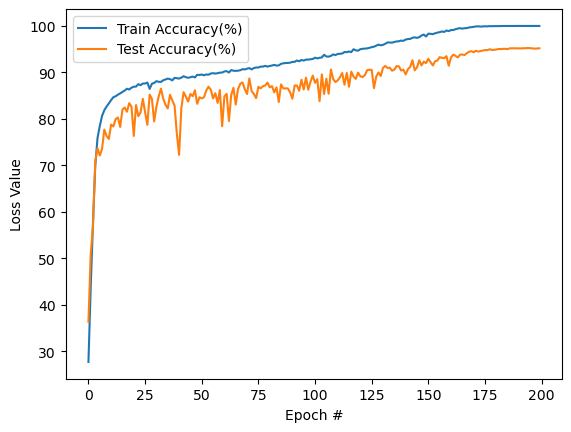

In [ ]:
plt.plot(train_acc_hist, label='Train Accuracy(%)')
plt.plot(test_acc_hist,label='Test Accuracy(%)')
plt.xlabel("Epoch #")
plt.ylabel("Loss Value")
plt.legend()
plt.savefig("result.png")
plt.show()